
In this lab, you’ll build and evaluate a simple fully‑connected neural network on the Fashion‑MNIST dataset, then explore two classic regularization strategies: $L_2$ weight decay and Dropout to combat overfitting.

## Dataset Description

The **Fashion‑MNIST** dataset is a drop‑in replacement for the original MNIST (handwritten digits) dataset, but contains 70,000 grayscale images of Zalando’s article images:

- **Total images**: 70,000 (60,000 training, 10,000 test)
- **Image size**: 28×28 pixels
- **Color**: Grayscale (single channel)
- **Classes**: 10 categories (T‑shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot)
- **Source**: Provided by Zalando Research, publicly available via [GitHub](https://github.com/zalandoresearch/fashion-mnist) and built into Keras/TensorFlow

Each class is balanced with exactly 6,000 images in the training set and 1,000 in the test set, making it ideal for benchmarking new models.

## Load Data & Inspect Examples


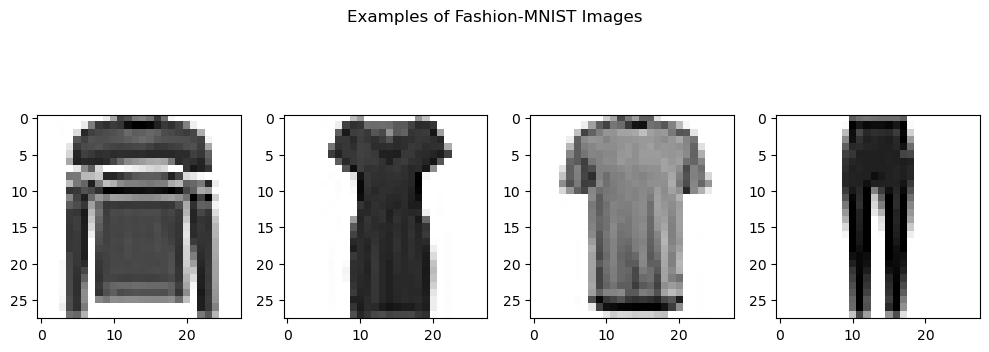

In [1]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Let's Load The data
(fx_train, fy_train), (fx_test, fy_test) = tf.keras.datasets.fashion_mnist.load_data()

## Assign class names
y = fy_train.flatten()

label_map = {
    0: "T‑shirt/top", 1: "Trouser",     2: "Pullover",
    3: "Dress",       4: "Coat",        5: "Sandal",
    6: "Shirt",       7: "Sneaker",     8: "Bag",
    9: "Ankle boot"
}

#### Assigning true labels
df = pd.DataFrame({'label': y})
df['class_name']  = df['label'].map(label_map)

indices = [5, 20, 789, 4567]  #indices of examples to plot
fig, axes = plt.subplots(1, len(indices), figsize=(10, 4))
fig.suptitle("Examples of Fashion‑MNIST Images")
for ax, idx in zip(axes, indices):
    ax.imshow(fx_train[idx], cmap='binary')

plt.tight_layout()
plt.show()


Now we print the annotated true labels:


In [2]:
print(df.class_name[indices])


5          Pullover
20            Dress
789     T‑shirt/top
4567        Trouser
Name: class_name, dtype: object


Let's see if the classes are balanced:


In [3]:
### Explore Classes distribution
summary = (
    df['label']
      .value_counts(sort=False)
      .rename_axis('label')
      .reset_index(name='count')
)
summary['percent']     = 100 * summary['count'] / summary['count'].sum()
summary['class_name']  = summary['label'].map(label_map)

# Reorder and drop count
summary = summary[['label', 'class_name', 'percent']]
print(summary)

   label   class_name  percent
0      9   Ankle boot     10.0
1      0  T‑shirt/top     10.0
2      3        Dress     10.0
3      2     Pullover     10.0
4      7      Sneaker     10.0
5      5       Sandal     10.0
6      1      Trouser     10.0
7      6        Shirt     10.0
8      4         Coat     10.0
9      8          Bag     10.0


Now we preprocess the data and build the Neural Network architecture:


In [4]:
#### Rehsape images into vectors
x_train = fx_train.reshape(-1, 28*28) / 255.0
x_test  = fx_test.reshape(-1, 28*28)  / 255.0

###Build model
model = models.Sequential([
    layers.Input(shape=(28*28,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In this next step we actually train our feed‐forward network on the Fashion‑MNIST training data and simultaneously hold out 20% of it for validation. Here’s what happens:



In [5]:
###Training the model
history = model.fit(
    x_train, fy_train,
    validation_split=0.2, ##20% for validation 
    epochs=30,
    batch_size=256
)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6891 - loss: 0.9261 - val_accuracy: 0.8366 - val_loss: 0.4610
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8463 - loss: 0.4399 - val_accuracy: 0.8538 - val_loss: 0.4221
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8597 - loss: 0.3980 - val_accuracy: 0.8556 - val_loss: 0.4013
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8727 - loss: 0.3572 - val_accuracy: 0.8663 - val_loss: 0.3673
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8741 - loss: 0.3487 - val_accuracy: 0.8674 - val_loss: 0.3713
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8856 - loss: 0.3237 - val_accuracy: 0.8833 - val_loss: 0.3339
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8892 - loss: 0.3062 - val_accuracy: 0.8785 - val_loss: 0.3408
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8948 - loss: 0.2935 - val_accuracy: 0.


We can plot the training vs.validation loss curves with:


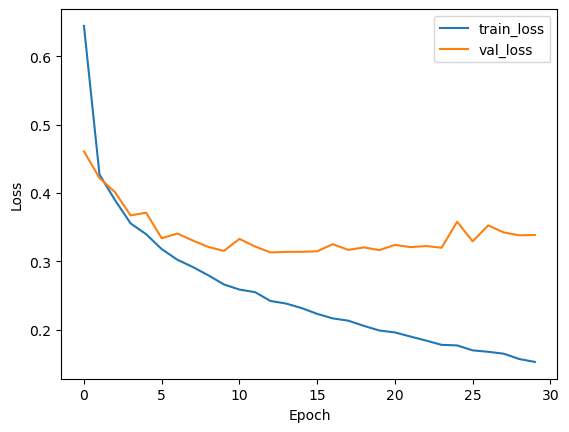

In [6]:
####Plot training Loss and validation loss over epochs
plt.figure()  
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()


This visualization lets us see how quickly the model is learning (the downward slope of the training loss), and how the validation loss eventually starts rising (a classic sign of over‑fitting once the network has learned too much noise).

## Fixing Overfitting

### L2 Weight Regularization

Penalize large weights by adding an $l_2$ penalty to the loss:


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6908 - loss: 1.2007 - val_accuracy: 0.8383 - val_loss: 0.6750
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8402 - loss: 0.6538 - val_accuracy: 0.8382 - val_loss: 0.6241
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8578 - loss: 0.5805 - val_accuracy: 0.8584 - val_loss: 0.5508
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8628 - loss: 0.5405 - val_accuracy: 0.8662 - val_loss: 0.5205
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8672 - loss: 0.5096 - val_accuracy: 0.8682 - val_loss: 0.5041
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.4810 - val_accuracy: 0.8721 - val_loss: 0.4841
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8760 - loss: 0.4618 - val_accuracy: 0.8670 - val_loss: 0.4952
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8785 - loss: 0.4497 - val_accuracy: 0.

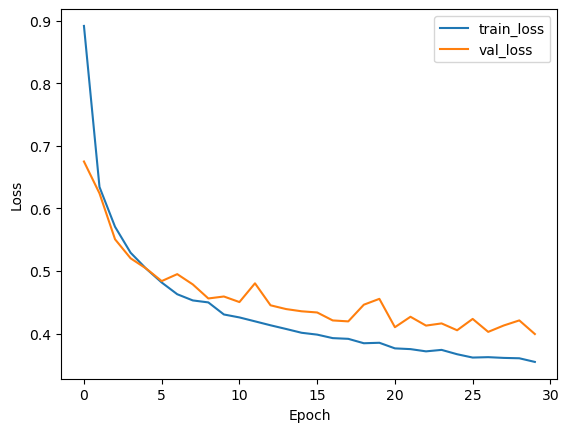

In [7]:
from keras.regularizers import l2
model_l2 = models.Sequential([
    layers.Input(shape=(28*28,)),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=l2(1e-3)), ## Penalty coefficient lambda = 1e-3
    layers.Dense(64, activation='relu',
                 kernel_regularizer=l2(1e-3)),
    layers.Dense(10, activation='softmax')
])

model_l2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_l2.fit(
    x_train, fy_train,
    validation_split=0.2, ##20% for validation 
    epochs=30,
    batch_size=256
)

plt.figure()  
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()


### Dropout

Randomly “drop” a fraction of neurons each update so the network can’t rely on any one feature:


Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5363 - loss: 1.3092 - val_accuracy: 0.8202 - val_loss: 0.5109
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7841 - loss: 0.6232 - val_accuracy: 0.8393 - val_loss: 0.4516
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8133 - loss: 0.5355 - val_accuracy: 0.8476 - val_loss: 0.4147
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8279 - loss: 0.4944 - val_accuracy: 0.8573 - val_loss: 0.3956
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8339 - loss: 0.4613 - val_accuracy: 0.8570 - val_loss: 0.3871
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8421 - loss: 0.4469 - val_accuracy: 0.8649 - val_loss: 0.3726
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8493 - loss: 0.4232 - val_accuracy: 0.8642 - val_loss: 0.3684
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8505 - loss: 0.4257 - val_accuracy: 0.

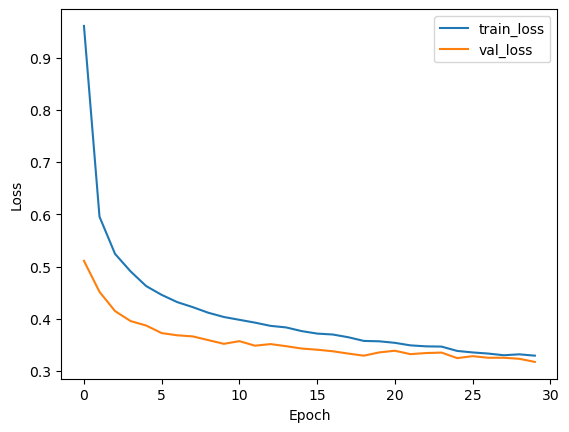

In [8]:
model_do = models.Sequential([
    layers.Input(shape=(28*28,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),              #drop 50% of activations
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),              #drop 30% activations
    layers.Dense(10, activation='softmax')
])

model_do.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_do.fit(
    x_train, fy_train,
    validation_split=0.2, ##20% for validation 
    epochs=30,
    batch_size=256
)

plt.figure()  
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()



## Final Evaluation

Evaluate your all three models on the held‑out test set:


In [9]:
for name, m in [('Baseline', model),
                ('L2',       model_l2),
                ('Dropout',  model_do)]:
    loss, acc = m.evaluate(x_test, fy_test, verbose=0)
    print(f"{name} Test Accuracy: {acc:.4f}")


Baseline Test Accuracy: 0.8866
L2 Test Accuracy: 0.8782
Dropout Test Accuracy: 0.8788




---

## Extensions & Questions

1. **Combine** both $L_2$ penalty and Dropout in a single model.  Does it outperform either alone?  
2. **Hyperparameter tuning:**  
   - Sweep $\lambda \in \{10^{-1},10^{-2},10^{-3}\}$ for $L_2$ 
   - Vary Dropout $rates \in \{0.2, 0.5, 0.7\}$  
   - Try different batch sizes (64, 128, 256) and optimizers (SGD, Adam, RMSprop)  
   - Increase the number of epochs
3. **Model depth:** Increase or decrease the number of hidden layers/units. How does capacity affect overfitting? 
4. **Visualize misclassifications:** Plot some examples the model got wrong—what patterns do you observe?







